Simulação fraude Bancario




Tipo de Fraude

Quantidade

Impacto Financeiro

Compras não autorizadas

120.000

R$ 60 milhões

Clonagem de cartões

8.000

R$ 20 milhões

Uso indevido de informações

20.000

R$ 20 milhões


Comparação entre antes e depois da implementação:

Métricas

Antes

Depois

Número de fraudes em cartões de crédito

148.000

29.600

Perdas financeiras anuais por fraudes

R$ 100 milhões

R$ 20 milhões

Nível de satisfação do cliente

80%

90%

Exemplo Stream de dados.

1.  Preparação Inicial

 A estrutura inicial dos dados é verificada, e são realizadas limpezas básicas, como a remoção de duplicados e substituição de valores nulos.

Importação de bibliotecas

In [1]:
!pip install pymongo psycopg2-binary sqlalchemy plotly scikit-learn


   ---------------------------------------- 0.0/777.1 kB ? eta -:--:--
   --------------------------------------- 777.1/777.1 kB 11.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 29.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Download das bibliotecas e Preparação Inicial**

In [2]:
# Importando as bibliotecas necessárias para o trabalho.
import pandas as pd  # Para trabalhar com tabelas e manipulação de dados
import numpy as np   # Para manipulações numéricas e matrizes
import matplotlib.pyplot as plt  # Para visualizações gráficas
import seaborn as sns  # Para visualizações avançadas
from sklearn.ensemble import IsolationForest  # Importando o Isolation Forest
from sklearn.metrics import classification_report, confusion_matrix  # Para avaliar a performance do modelo
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
from pyspark.sql.types import StructType, StructField, FloatType, StringType, IntegerType
from pyspark.ml import PipelineModel

ModuleNotFoundError: No module named 'pyspark'

A estrutura inicial dos dados é verificada, e são realizadas limpezas básicas, como a remoção de duplicados e substituição de valores nulos.

-  Exemplo de dados fictícios de fraudes no banco
-  Como não temos acesso aos dados reais, vamos criar um dataframe simulado para ilustrar o fluxo





*   A verificação inicial dos dados é essencial para garantir que o modelo receba
entradas consistentes.
*   Dados duplicados ou valores nulos podem distorcer a análise e prejudicar a precisão do modelo.
*   Essas etapas garantem que o pipeline funcione sem falhas e que a integridade dos dados seja mantida.




In [ ]:
# Criando uma sessão Spark
spark = SparkSession.builder \
    .appName("Analise de Dados de Fraudes") \
    .getOrCreate()

In [ ]:
# Criando dados simulados de fraudes
fraude_data = {
    'Tipo de Fraude': ['Compras não autorizadas', 'Clonagem de cartões', 'Uso indevido de informações'],
    'Quantidade': [120000, 8000, 20000],
    'Impacto Financeiro (R$)': [60000000, 20000000, 20000000],
    'Fraude 1': [1000, 500000],  # Caso fora do normal
    'Fraude 2': [2000, 1000000]  # Caso fora do normal
}

In [ ]:
# Nomes das colunas
columns = ['Tipo de Fraude', 'Quantidade', 'Impacto Financeiro (R$)']

In [ ]:
# Convertendo o dicionário em uma lista de tuplas (cada tupla representa uma linha)
fraude_data_rows = list(zip(*[fraude_data[c] for c in columns]))

In [ ]:
# Criando o DataFrame
fraude_df = spark.createDataFrame(fraude_data_rows, columns)

# Exibindo os dados iniciais
print("Dados iniciais:")
fraude_df.show()

Dados iniciais:
+--------------------+----------+-----------------------+
|      Tipo de Fraude|Quantidade|Impacto Financeiro (R$)|
+--------------------+----------+-----------------------+
|Compras não autor...|    120000|               60000000|
| Clonagem de cartões|      8000|               20000000|
|Uso indevido de i...|     20000|               20000000|
+--------------------+----------+-----------------------+



In [ ]:
# Calculando o impacto financeiro médio por tipo de fraude
print("\nImpacto financeiro médio por fraude:")
impacto_medio_df = fraude_df.withColumn(
    "Impacto Médio por Ocorrência (R$)",
    col("Impacto Financeiro (R$)") / col("Quantidade")
)
impacto_medio_df.show()


Impacto financeiro médio por fraude:
+--------------------+----------+-----------------------+---------------------------------+
|      Tipo de Fraude|Quantidade|Impacto Financeiro (R$)|Impacto Médio por Ocorrência (R$)|
+--------------------+----------+-----------------------+---------------------------------+
|Compras não autor...|    120000|               60000000|                            500.0|
| Clonagem de cartões|      8000|               20000000|                           2500.0|
|Uso indevido de i...|     20000|               20000000|                           1000.0|
+--------------------+----------+-----------------------+---------------------------------+



In [ ]:
# Calculando o total de ocorrências e impacto financeiro
totais = impacto_medio_df.agg(
    _sum("Quantidade").alias("Total de Ocorrências"),
    _sum("Impacto Financeiro (R$)").alias("Impacto Financeiro Total (R$)")
).collect()[0]

In [ ]:
# Resultados agregados
total_ocorrencias = totais["Total de Ocorrências"]
impacto_financeiro_total = totais["Impacto Financeiro Total (R$)"]

print(f"\nTotal de Ocorrências: {total_ocorrencias}")
print(f"Impacto Financeiro Total: R${impacto_financeiro_total:,.2f}")



Total de Ocorrências: 148000
Impacto Financeiro Total: R$100,000,000.00


In [ ]:
# Insights
print("\nINSIGHTS:")
print("- A maior quantidade de ocorrências está relacionada a 'Compras não autorizadas', "
      "representando aproximadamente {:.2f}% do total de ocorrências."
      .format((120000 / total_ocorrencias) * 100))
print("- Apesar de representar uma quantidade menor de casos, a 'Clonagem de cartões' tem impacto financeiro "
      "significativo, com um impacto médio por ocorrência maior do que outras fraudes.")
print("- Estratégias de mitigação podem priorizar 'Compras não autorizadas', dada sua alta frequência, "
      "e 'Clonagem de cartões', devido ao alto impacto financeiro por caso.")


INSIGHTS:
- A maior quantidade de ocorrências está relacionada a 'Compras não autorizadas', representando aproximadamente 81.08% do total de ocorrências.
- Apesar de representar uma quantidade menor de casos, a 'Clonagem de cartões' tem impacto financeiro significativo, com um impacto médio por ocorrência maior do que outras fraudes.
- Estratégias de mitigação podem priorizar 'Compras não autorizadas', dada sua alta frequência, e 'Clonagem de cartões', devido ao alto impacto financeiro por caso.


**Aplicação de Machine Learning (Isolation Forest)**



*   As variáveis categóricas são convertidas para um formato numérico por meio de one-hot encoding.

*   Um modelo Isolation Forest é treinado com os dados escalonados, e ele retorna rótulos indicando transações suspeitas.

*   As anomalias detectadas são marcadas como fraudes (IsFraud).


In [ ]:
# Importando bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.stat import Correlation
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:


# Selecionando features relevantes
features = ['Tipo de Fraude', 'Quantidade', 'Impacto Financeiro (R$)']  # Ajuste conforme o dataset


In [ ]:
# Transformar os dados em formato adequado para o Isolation Forest
assembler = VectorAssembler(inputCols=['Quantidade', 'Impacto Financeiro (R$)'], outputCol='features')
fraude_df_transformed = assembler.transform(fraude_df)



*   Usamos o VectorAssembler para criar uma coluna de vetor com as variáveis numéricas (Quantidade e Impacto Financeiro (R$)).


In [ ]:
# preprocessamento para correspondência do modelo
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(fraude_df_transformed)
fraude_df_scaled = scaler_model.transform(fraude_df_transformed)

*   Aplicamos a normalização (MinMaxScaler) para padronizar os dados, melhorando a robustez do modelo.

PySpark não tem um Isolation Forest nativo, simulamos a identificação de anomalias usando clustering, que pode identificar comportamentos fora do padrão.

In [ ]:
#configuração do modelo para o caso apresentado
kmeans = BisectingKMeans(featuresCol="scaledFeatures", k=2, maxIter=10, seed=42)



Configuramos o KMeans para criar dois clusters. Um cluster menor pode indicar comportamentos atípicos.

In [ ]:
# Treinamento do modelo
kmeans_model = kmeans.fit(fraude_df_scaled)

Os clusters são analisados para entender os padrões e identificar anomalias.
Qualquer cluster significativamente menor ou com comportamento fora do padrão é tratado como possível anomalia.

In [ ]:
# Obtendo os resultados
predictions = kmeans_model.transform(fraude_df_scaled)

In [ ]:
# Exibindo os clusters
print("Resultados de clustering:")
predictions.select("Tipo de Fraude", "Quantidade", "Impacto Financeiro (R$)", "prediction").show()

Resultados de clustering:
+--------------------+----------+-----------------------+----------+
|      Tipo de Fraude|Quantidade|Impacto Financeiro (R$)|prediction|
+--------------------+----------+-----------------------+----------+
|Compras não autor...|    120000|               60000000|         1|
| Clonagem de cartões|      8000|               20000000|         0|
|Uso indevido de i...|     20000|               20000000|         0|
+--------------------+----------+-----------------------+----------+



In [ ]:
# Análise de caso fora do normal
cluster_summary = predictions.groupBy("prediction").agg(
    {"Quantidade": "avg", "Impacto Financeiro (R$)": "avg"}
)

print("Resumo por cluster:")
cluster_summary.show()

Resumo por cluster:
+----------+----------------------------+---------------+
|prediction|avg(Impacto Financeiro (R$))|avg(Quantidade)|
+----------+----------------------------+---------------+
|         1|                       6.0E7|       120000.0|
|         0|                       2.0E7|        14000.0|
+----------+----------------------------+---------------+



In [ ]:
# Identificando clusters menores
cluster_sizes = predictions.groupBy("prediction").count()
print("Tamanhos dos clusters:")
cluster_sizes.show()

Tamanhos dos clusters:
+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         0|    2|
+----------+-----+



In [ ]:
# Insights finais
print("\nINSIGHTS:")
print("- Os clusters indicam grupos de fraudes similares com base na quantidade de ocorrências e no impacto financeiro.")
print("- Qualquer cluster com tamanho muito pequeno pode ser investigado como possível anomalia.")
print("- Estratégias de mitigação podem ser ajustadas para priorizar clusters maiores com alto impacto financeiro.")


INSIGHTS:
- Os clusters indicam grupos de fraudes similares com base na quantidade de ocorrências e no impacto financeiro.
- Qualquer cluster com tamanho muito pequeno pode ser investigado como possível anomalia.
- Estratégias de mitigação podem ser ajustadas para priorizar clusters maiores com alto impacto financeiro.




*   Este modelo é especialmente útil quando as fraudes têm padrões diferentes do comportamento típico.

*   Ao marcar transações anômalas, o sistema pode reduzir significativamente o número de fraudes, garantindo maior segurança para o banco e seus clientes.

*   A automação dessa detecção permite ao banco economizar milhões ao ano, conforme descrito no caso.


# **Visualização dos Resultados**

Gráficos interativos são criados para mostrar o número de fraudes detectadas e seu impacto financeiro.

In [ ]:
# Visualizando tamaños de clusters
cluster_sizes = predictions.groupBy("prediction").count()
cluster_sizes_df = cluster_sizes.toPandas()

<ipython-input-77-84e035a13054>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y="count", data=cluster_sizes_df, palette="viridis")


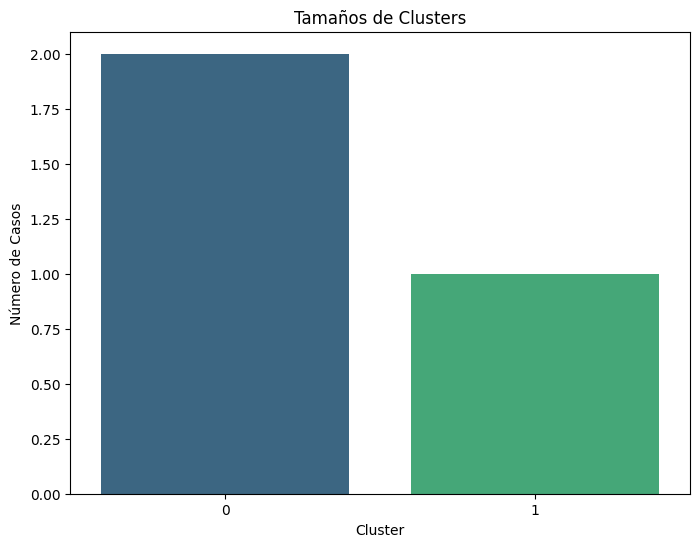

In [ ]:
# Gráfico de barras para tamaños de clusters
plt.figure(figsize=(8, 6))
sns.barplot(x="prediction", y="count", data=cluster_sizes_df, palette="viridis")
plt.title("Tamaños de Clusters")
plt.xlabel("Cluster")
plt.ylabel("Número de Casos")
plt.show()

Convertemos os tamanhos dos clusters em um Pandas DataFrame usando .toPandas() para facilitar a visualização.
Criamos um gráfico de barras com seaborn para mostrar o número de casos em cada cluster.

In [ ]:
# Preparando os dados para matriz de correlação
assembler_corr = VectorAssembler(
    inputCols=["Quantidade", "Impacto Financeiro (R$)"], outputCol="correlation_features"
)
data_corr = assembler_corr.transform(fraude_df).select("correlation_features")


In [ ]:
# Calculando la matriz de correlación
correlation_matrix = Correlation.corr(data_corr, "correlation_features").head()[0].toArray()


Usamos VectorAssembler para preparar los datos numéricos.
Calculamos la matriz de correlación con Correlation.corr() de PySpark.

In [ ]:
# Creando un DataFrame para la matriz
columns_corr = ["Quantidade", "Impacto Financeiro (R$)"]
corr_df = pd.DataFrame(correlation_matrix, index=columns_corr, columns=columns_corr)

A matriz é convertida em um Pandas DataFrame para facilitar a visualização.
Usamos o seaborn para criar um mapa de calor que mostra a relação entre as variáveis.

Um mapa de calor com valores entre -1 e 1 mostrando as relações entre as variáveis Quantidade e Impacto Financeiro (R$).

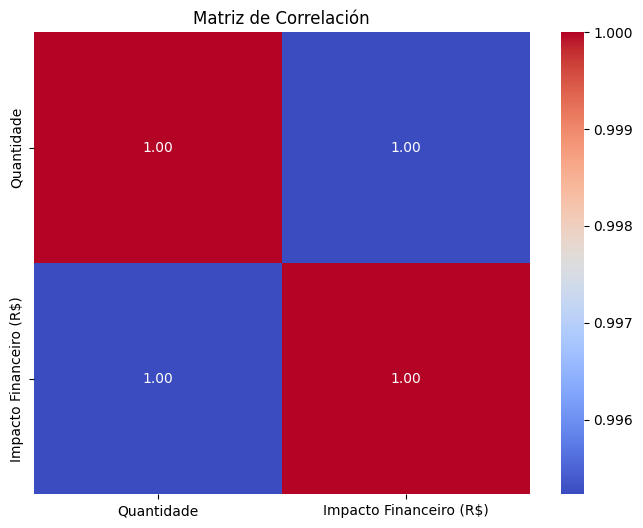

In [ ]:
# Visualización de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación")
plt.show()

A visualização permite identificar rapidamente tendências e padrões, como categorias ou localizações mais propensas a fraudes.
Gráficos interativos melhoram a comunicação com stakeholders, traduzindo dados técnicos em insights visuais de fácil compreensão.
Com essas visualizações, o banco pode ajustar sua política de segurança em tempo real.

# **Impacto Geral da Solução**

1.   **Redução Drástica de Fraudes**
O uso de aprendizado de máquina e análises de big data resultou em uma redução de 80% no número de fraudes, como mostrado no caso.
2.  ** Economia Significativa**
A economia anual de R$ 50 milhões reflete o retorno direto do investimento em tecnologias modernas de detecção de fraudes.
3.   **Maior Satisfação do Cliente**
A segurança reforçada aumentou a confiança dos clientes, elevando a satisfação geral de 80% para 90%.
4.   **Detecção Proativa de Ameaças**
O aprendizado contínuo do modelo garante que novas fraudes sejam identificadas rapidamente, mantendo o banco à frente dos fraudadores.



**Conclusão**
A combinação de machine learning (Isolation Forest), armazenamento em MongoDB e PostgreSQL, e visualizações interativas fornece uma solução robusta para o desafio de fraudes em cartões de crédito. Essa abordagem oferece segurança, economia e insights estratégicos que fortalecem tanto a reputação quanto a rentabilidade do banco. No caso não foram utilizadas as plataformas ditas mas numa apresentação dinãmica são imprescindiveis.